# Dim 3 point 

Compare different experiment trainings. 


In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-12 02:10:03.742034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 02:10:03.755557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 02:10:03.759729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [2]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          #'mag_nabla_h_widened',
                                          #'filter_scale', 
                                          #'mag_nabla_u_widened',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim',
                                          'vphp_rotated_nondim'],
                    
                    'coeff_channels'  : [], 

                    'extra_channels'   : ['uphp_rotated',
                                        'vphp_rotated', 
                                        'mag_nabla_h_widened',
                                        'mag_nabla_u_widened',
                                        'filter_scale'],

                    'use_coeff_channels': False,

                    'all_time_range': slice(200, 2000),
                    'train_time_range': slice(0, 1024),
                    'test_time_range' : slice(-128, None),
                    'eval_time_range' : slice(-256, -128),
                    'num_train_batches': 128, 
                    'num_test_batches' : 8, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [3]:
experiment_config['all_time_range'] = slice(-256,None)
experiment_config['eval_time_range'] = slice(-256,-128)

In [4]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True
                             )

In [5]:
DT.simulation_data['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 256, xh: 100, yh: 108, zl: 2, Xn: 3,
                                      Yn: 3, zi: 3)
    Coordinates:
      * Time                         (Time) object 2kB 0092-08-01 00:00:00 ... 00...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
      * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/67)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
        ...                           ...
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 44MB dask.array<chunksize=(4, 2, 107, 99), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 44MB dask.array<chunksize=(4, 2, 107, 99), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 44MB dask.array<chunksize=(4, 2, 107, 99), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 44MB dask.array<chunksize=(4, 2, 107, 99), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh) float64 22MB dask.array<chunksize=(4, 108, 100), meta=np.ndarray>
        single_layer_mask            (Time, yh, xh) float64 22MB dask.array<chunksize=(4, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [6]:
exp_sets = { 'DG_only': { 'sel_sim' :'DG' }, 
             'P2L_only':{ 'sel_sim' :'P2L' }, 
             'DG_P2L':{'sel_sim' :['DG','P2L']}   
            }

In [7]:
for set_keys in exp_sets.keys(): 
    exp_sets[set_keys]['save_dir'] = experiment_config['exp_ckpt_save_dir'] + set_keys


In [19]:
exp_sets

{'DG_only': {'sel_sim': 'DG',
  'save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/DG_only',
  'eval_sys': <evaluation.EvalSystem at 0x7d8960668410>},
 'P2L_only': {'sel_sim': 'P2L',
  'save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/P2L_only',
  'eval_sys': <evaluation.EvalSystem at 0x7d895465c4a0>},
 'DG_P2L': {'sel_sim': ['DG', 'P2L'],
  'save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/DG_P2L',
  'eval_sys': <evaluation.EvalSystem at 0x7d8932493ce0>}}

In [8]:
# Load in and get the models ready to evaluate
for set_keys in exp_sets.keys():
    print(exp_sets[set_keys]['save_dir'])
    exp_sets[set_keys]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                             input_channels=experiment_config['input_channels'],
                                             output_channels=experiment_config['output_channels'], 
                                             coeff_channels=experiment_config['coeff_channels'], 
                                             extra_channels=experiment_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= experiment_config['eval_time_range'], 
                                             num_inputs=experiment_config['num_inputs'], 
                                             shape=experiment_config['network_shape'], 
                                             ckpt_dir=exp_sets[set_keys]['save_dir'],
                                             use_coeff_channels=experiment_config['use_coeff_channels'])

    
    exp_sets[set_keys]['eval_sys'].read_ann_regression_model()
    exp_sets[set_keys]['eval_sys'].read_eval_data()
    exp_sets[set_keys]['eval_sys'].predict()

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/DG_only
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/P2L_only
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/evaluate_model_design/impact_train_experiment/window_3/DG_P2L


In [9]:
# Compute some metrics for each model 
for set_keys in exp_sets.keys():
    print(set_keys)
    exp_sets[set_keys]['eval_sys'].dimensionalize()

 
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='all', dims=['Time','xh','yh','zl'], use_default_subregions=True)
    
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='layer_wise', dims=['Time','xh','yh'], use_default_subregions=True)
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='layer_wise', dims=['Time','xh','yh'], use_default_subregions=True)

    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'], use_default_subregions=True)
    exp_sets[set_keys]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'], use_default_subregions=True)

DG_only
P2L_only
DG_P2L


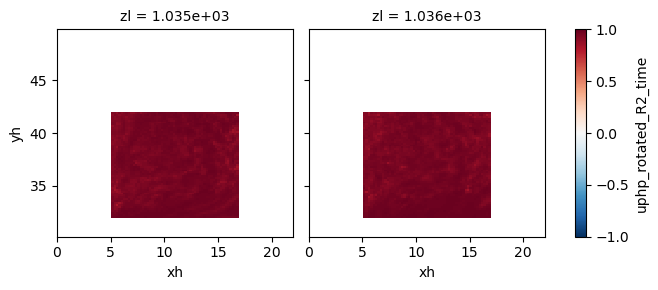

In [10]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)

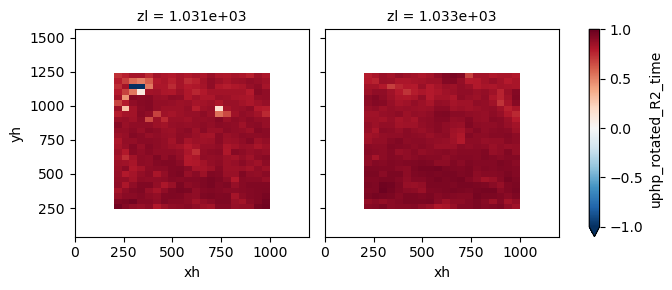

In [11]:
exp_sets['DG_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['200'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)

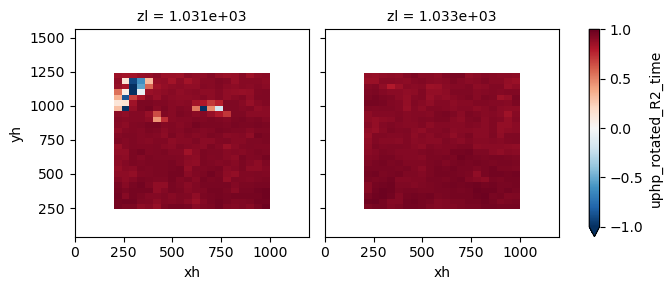

In [12]:
exp_sets['P2L_only']['eval_sys'].eval_datatree.ml_dataset['P2L']['200'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)

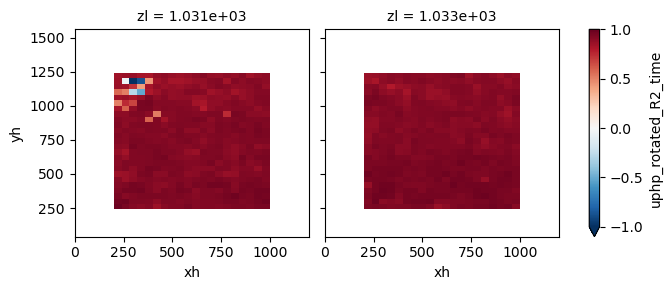

In [13]:
exp_sets['DG_P2L']['eval_sys'].eval_datatree.ml_dataset['P2L']['200'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)

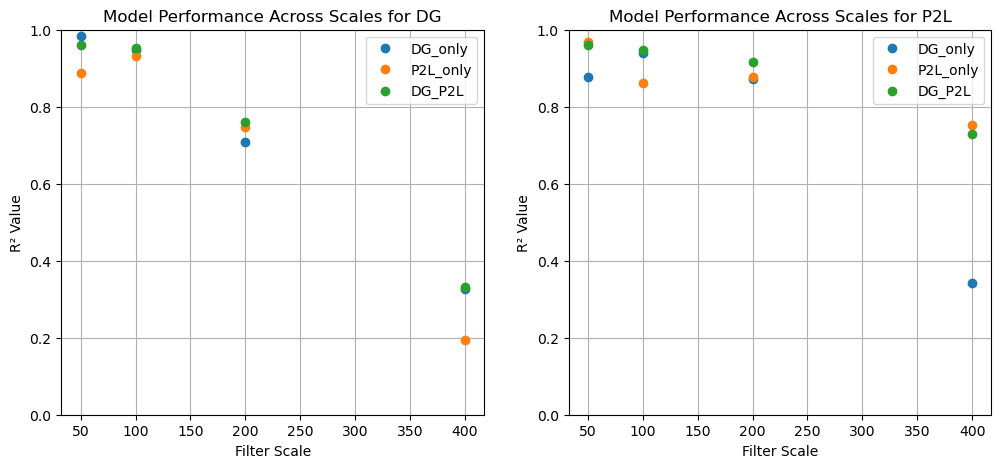

In [14]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(12, 5))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in exp_sets.keys():
        flag = 0
        exp_name = data_key
        
        for scale in experiment_config['filter_scales']:
            R2_value = exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_R2_all.values
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Model Performance Across Scales for " + data_key )

#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

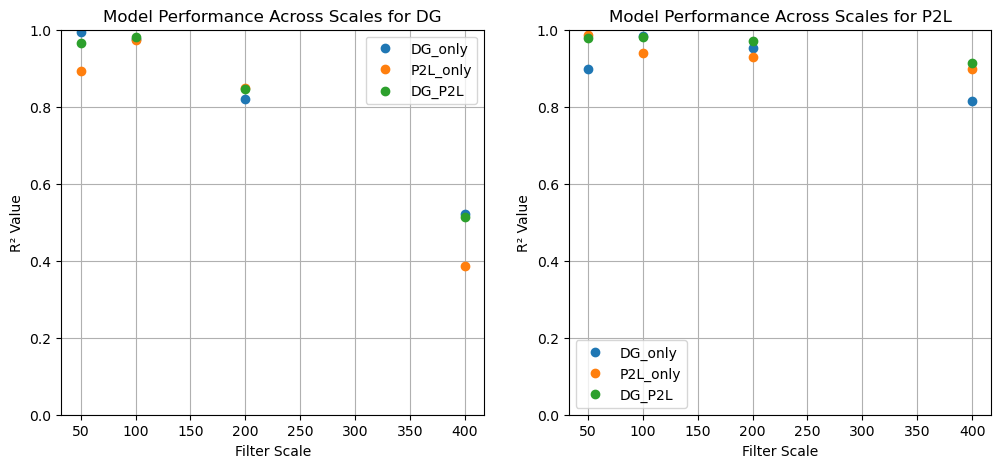

In [15]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(12, 5))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in exp_sets.keys():
        flag = 0
        exp_name = data_key
        
        for scale in experiment_config['filter_scales']:
            R2_value = exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_R2_all.values
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Model Performance Across Scales for " + data_key )

#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

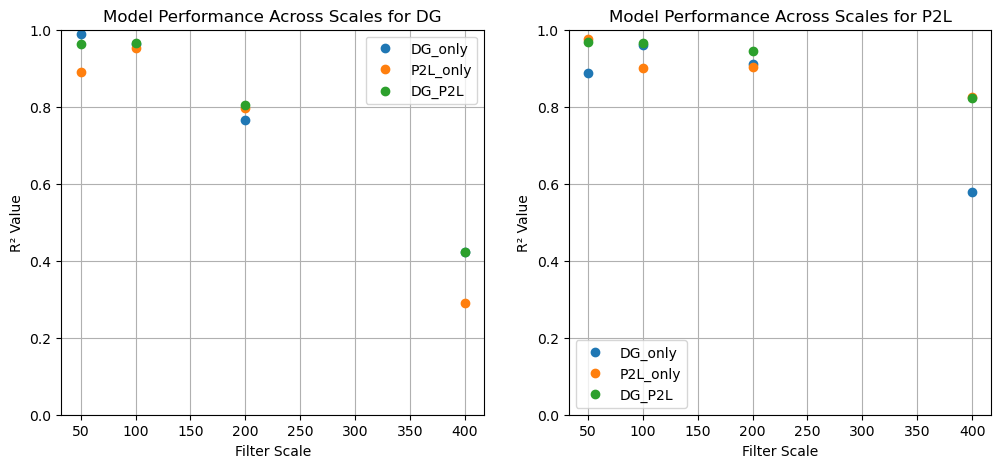

In [18]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(exp_sets.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(12, 5))

for i, data_key in enumerate(['DG','P2L']):
    plt.subplot(1,2,1+i)
    for model_key in exp_sets.keys():
        flag = 0
        exp_name = data_key
        
        for scale in experiment_config['filter_scales']:
            R2_value = 0.5*(exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].uphp_rotated_R2_all.values +
                            exp_sets[model_key]['eval_sys'].eval_datatree.ml_dataset[data_key][scale].vphp_rotated_R2_all.values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color)
    
    #num_params = train_sets[model_key]['eval_sys'].regress_sys.network.count_parameters()
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title("Model Performance Across Scales for " + data_key )

#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")